In [28]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [30]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [33]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [35]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [37]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\ccogg\AppData\Local\Temp\ipykernel_39172\4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [57]:
# View all of the classes that automap found
mapped_classes = Base.classes.keys()
print(list(mapped_classes))

['measurement', 'station']


In [63]:
# Save references to each table
# Map each table to a variable
Measurement = Base.classes.measurement
Station = Base.classes.station

In [65]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [67]:

from sqlalchemy import desc
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(desc(Measurement.date)).first()

# Display the most recent date
print(f"The most recent date in the dataset is: {most_recent_date[0]}")

The most recent date in the dataset is: 2017-08-23


<Figure size 1400x800 with 0 Axes>

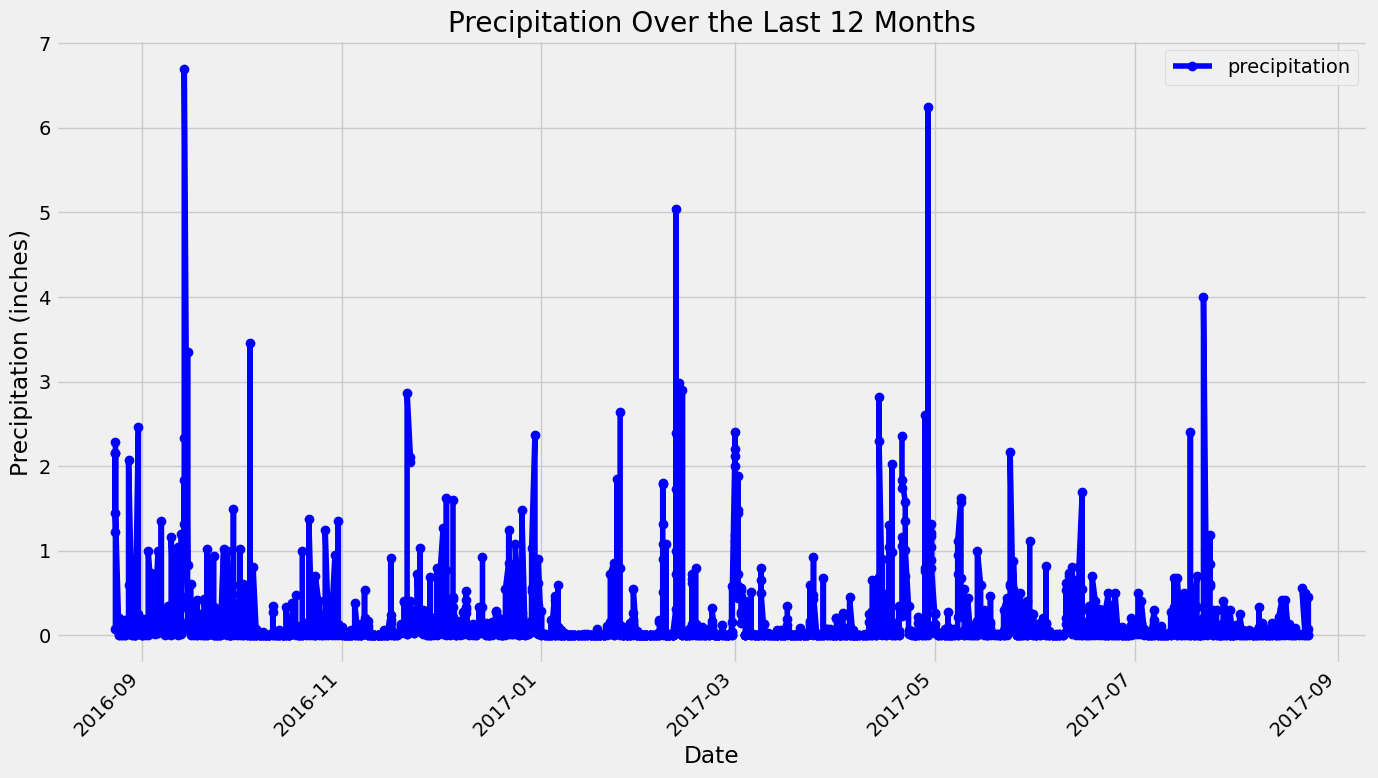

In [97]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
from datetime import datetime, timedelta

most_recent_date = session.query(Measurement.date).order_by(desc(Measurement.date)).first()[0]
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')

#Calculate the date one year before the most recent date
one_year_ago = most_recent_date - timedelta(days=365)

#Perform a query to retrieve the date and precipitation scores for the last 12 months
precip_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

#Save the query results as a Pandas DataFrame and explicitly set the column names
precip_df = pd.DataFrame(precip_data, columns=['date', 'precipitation'])

#Convert the date column to datetime format for sorting and manipulation
precip_df['date'] = pd.to_datetime(precip_df['date'])

#Sort the DataFrame by date
precip_df = precip_df.sort_values(by='date')

#Plot the precipitation data using Pandas Plotting with Matplotlib
plt.figure(figsize=(14,8))
precip_df.plot(x='date', y='precipitation', marker='o', linestyle='-', color='b', figsize=(14,8))
plt.title('Precipitation Over the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [99]:
# Use Pandas to calculate the summary statistics for the precipitation data
# Calculate the summary statistics for the precipitation data
precip_stats = precip_df['precipitation'].describe()

# Display the summary statistics
print(precip_stats)

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [101]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()

# Step 3: Display the result
print(f"Total number of stations in the dataset: {total_stations}")

Total number of stations in the dataset: 9


In [103]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(desc(func.count(Measurement.station))).\
    all()

# Step 2: Display the stations and their counts
print("Most Active Stations (station ID and number of observations):")
for station, count in most_active_stations:
    print(f"Station: {station}, Count: {count}")

Most Active Stations (station ID and number of observations):
Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [111]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Step 1: Retrieve the most active station ID
most_active_station = most_active_stations[0][0]  # Get the station ID of the most active station


    
# Step 2: Perform a query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(
    func.min(Measurement.tobs),  # Lowest temperature
    func.max(Measurement.tobs),  # Highest temperature
    func.avg(Measurement.tobs)   # Average temperature
).filter(Measurement.station == most_active_station).all()

# Step 3: Display the results
lowest_temp, highest_temp, avg_temp = temperature_stats[0]
print(f"Station ID: {most_active_station}")
print(f"Lowest Temperature: {lowest_temp} °F")
print(f"Highest Temperature: {highest_temp} °F")
print(f"Average Temperature: {avg_temp:.2f} °F")

Station ID: USC00519281
Lowest Temperature: 54.0 °F
Highest Temperature: 85.0 °F
Average Temperature: 71.66 °F


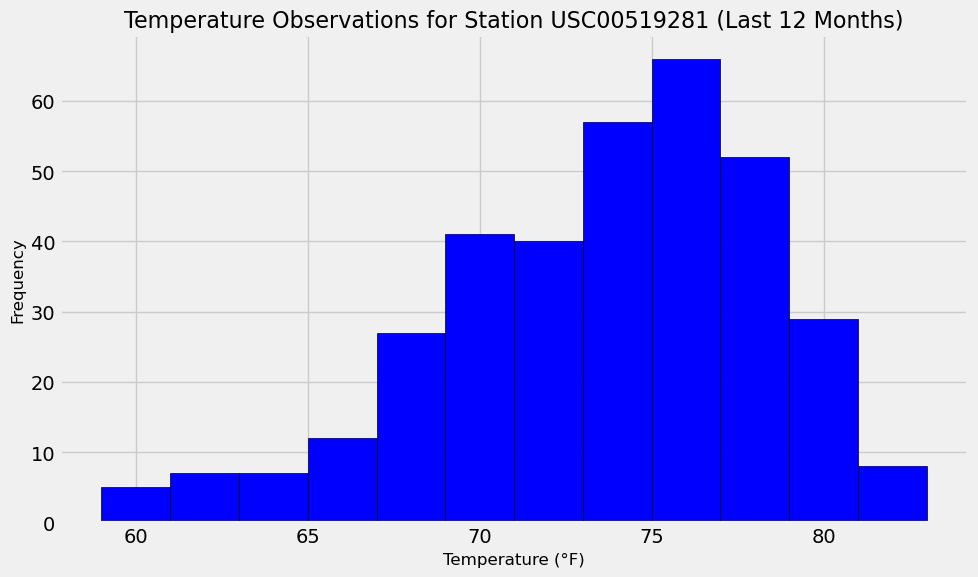

In [113]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Step 1: Retrieve the most active station ID
most_active_station = most_active_stations[0][0]  # Get the station ID of the most active station

# Step 2: Calculate the date one year ago from the most recent date
one_year_ago = most_recent_date - timedelta(days=365)

# Step 3: Query the last 12 months of temperature observation data for the most active station
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Step 4: Convert the query results to a list of temperatures
temperature_list = [temp[0] for temp in temperature_data]

# Step 5: Plot the temperature data as a histogram
plt.figure(figsize=(10,6))
plt.hist(temperature_list, bins=12, color='blue', edgecolor='black')
plt.title(f'Temperature Observations for Station {most_active_station} (Last 12 Months)', fontsize=16)
plt.xlabel('Temperature (°F)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()

# Close Session

In [116]:
# Display all columns of the Measurement table
for column in Measurement.__table__.columns:
    print(column.name)

id
station
date
prcp
tobs


In [118]:
# Close Session
session.close()